In [54]:
import torch
import torchvision
import torchvision.transforms as transforms
from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar, TraceDict
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
import pandas as pd
import seaborn as sns

In [3]:


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         x = self.softmax(x)
        return x


In [59]:
folder

'original'

In [60]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((32,32))])
df = pd.read_csv('/share/u/rohit/eigens/notebooks/object_prompts.csv')
classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model = vgg13_bn(pretrained=True)
model.to(device)
main_folder = '/share/u/rohit/www/eigens/'
folders = os.listdir(main_folder)
batch_size = 500
topk =1
accuracies = []
classes_list = []
models_list = []
for folder in folders:
    total_count = {}
    true_pred = {}
    if folder == 'original':
        class_ = 'all'
        model_ = 'Original'
    else:
        class_ = folder.split('-')[1]
        model_ = f'Edited {class_}'
    
    names = os.listdir(os.path.join(main_folder, folder))
    names = [name for name in names if '.png' in name or '.jpg' in name]

    images = []
    for name in names:
        img = Image.open(os.path.join(os.path.join(main_folder,folder), name))
        batch = transform(img)
        images.append(batch)
#     if batch_size == None:
#         batch_size = len(names)
#     if batch_size > len(names):
#         batch_size = len(names)
    images = torch.stack(images)
    # Step 4: Use the model and print the predicted category
    for i in range(((len(names)-1)//batch_size)+1):
        batch = images[i*batch_size: min(len(names), (i+1)*batch_size)].to(device)
        with torch.no_grad():
            outputs = model(batch)
            _, predictions = torch.max(outputs, 1)
    for i, name in enumerate(names):
        case_number =  int(name.split('/')[-1].split('_')[0])
        true = df.loc[df.case_number==case_number].object.item()
        predicted = classes[predictions[i]]
        total_count[true] = total_count.get(true, 0) + 1 
        if true==predicted:
            true_pred[true]= true_pred.get(true, 0) + 1
    print(folder)
    for key in total_count.keys():
        print(f'Accuracy of {key}: {true_pred[key]/total_count[key]}')
        accuracies.append(true_pred[key]/total_count[key])
        classes_list.append(key)
        models_list.append(model_)

erasing-dog-with-preservation
Accuracy of dog: 0.2
Accuracy of plane: 0.8
Accuracy of ship: 0.49
Accuracy of car: 0.58
Accuracy of bird: 0.59
erasing-ship-with-preservation
Accuracy of ship: 0.24
Accuracy of plane: 0.76
Accuracy of dog: 0.4
Accuracy of car: 0.66
Accuracy of bird: 0.64
erasing-car-with-preservation
Accuracy of car: 0.3
Accuracy of plane: 0.75
Accuracy of ship: 0.47
Accuracy of dog: 0.42
Accuracy of bird: 0.64
erasing-plane-with-preservation
Accuracy of plane: 0.32
Accuracy of ship: 0.51
Accuracy of dog: 0.47
Accuracy of car: 0.64
Accuracy of bird: 0.69
erasing-bird-with-preservation
Accuracy of bird: 0.12
Accuracy of plane: 0.85
Accuracy of ship: 0.57
Accuracy of dog: 0.42
Accuracy of car: 0.59
original
Accuracy of plane: 0.8
Accuracy of ship: 0.52
Accuracy of dog: 0.41
Accuracy of car: 0.57
Accuracy of bird: 0.63


In [61]:
df_plot = {'Model': models_list,
          'Class': classes_list,
          'Accuracy': accuracies}

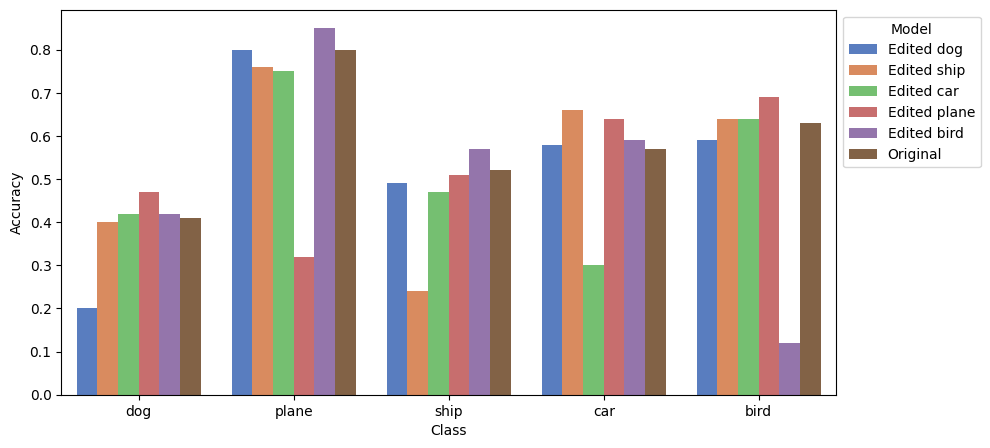

In [69]:
df_plot = pd.DataFrame(df_plot)

plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_plot, x='Class', y='Accuracy',hue = 'Model', palette="muted")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<AxesSubplot: xlabel='Class', ylabel='Accuracy'>

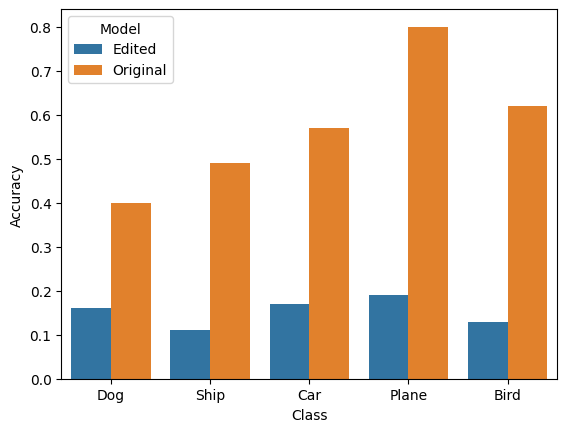

In [52]:
df_plot = pd.DataFrame(df_plot)

sns.barplot(data=df_plot, x='Class', y='Accuracy',hue = 'Model')
# plt.title('Editing Knowledge of Diffusion Models')

In [42]:
import os

import torch
import torch.nn as nn

__all__ = [
    "VGG",
    "vgg11_bn",
    "vgg13_bn",
    "vgg16_bn",
    "vgg19_bn",
]


class VGG(nn.Module):
    def __init__(self, features, num_classes=10, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        # CIFAR 10 (7, 7) to (1, 1)
        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            # nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    "A": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "B": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "D": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "E": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, device, **kwargs):
    if pretrained:
        kwargs["init_weights"] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = torch.load(
             "state_dicts/" + arch + ".pt", map_location=device
        )
        model.load_state_dict(state_dict)
    return model


def vgg11_bn(pretrained=False, progress=True, device="cpu", **kwargs):
    """VGG 11-layer model (configuration "A") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg11_bn", "A", True, pretrained, progress, device, **kwargs)


def vgg13_bn(pretrained=False, progress=True, device="cpu", **kwargs):
    """VGG 13-layer model (configuration "B") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg13_bn", "B", True, pretrained, progress, device, **kwargs)


def vgg16_bn(pretrained=False, progress=True, device="cpu", **kwargs):
    """VGG 16-layer model (configuration "D") with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg16_bn", "D", True, pretrained, progress, device, **kwargs)


def vgg19_bn(pretrained=False, progress=True, device="cpu", **kwargs):
    """VGG 19-layer model (configuration 'E') with batch normalization
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg("vgg19_bn", "E", True, pretrained, progress, device, **kwargs)

In [43]:
model = vgg13_bn(pretrained=True)

In [45]:
model.to(device)
out = model(batch)

In [46]:
out

tensor([[ 4.2266, -0.4370,  0.2412,  ...,  0.0436, -0.0134, -0.0545],
        [ 4.3933, -0.4164,  0.1118,  ..., -0.0767,  0.0470, -0.3399],
        [ 4.9385, -0.5143,  0.4112,  ..., -0.2256,  0.1572, -0.3879],
        ...,
        [ 0.3547, -2.4373,  5.8645,  ..., -0.5893, -1.0333, -2.1563],
        [-2.3920, -0.4047,  0.4183,  ..., -2.7082, -1.7371, -1.2957],
        [-0.9324, -2.0703,  0.5152,  ..., -1.3123, -0.8599, -1.2145]],
       device='cuda:0', grad_fn=<AddmmBackward0>)